# IBM Applied Data Science Capstone Course by Coursera

#### Final Assignment

## San Francisco's gym market geografy

In the following work, the gyms in the city of San Francisco are analized from a Geographical distribution point of view. Finally some advices are given to potential entrepreneurs who wants to enter in the industry.

### Creating the DataFrame of Neighborhoods

In [1]:
#importing libraries
import numpy as np
import requests
import pandas as pd
import csv
from geopy import geocoders
from geopy.geocoders import Nominatim
import folium
import json
import matplotlib as mp
from sklearn.cluster import KMeans
from bs4 import BeautifulSoup
import xml

In [2]:
#creating a dataframe with the San Francisco's neighborhoods
neighborhoods = pd.read_csv('c:/Users/tummi/Desktop/Corsi e learning/Attuali/IBM DS professional certificate (in corso)/9. Applied Capstone Project/Final Projcet/SFFind_Neighborhoods.csv')
neighborhoods.drop('LINK', axis=1, inplace=True)
neighborhoods.drop('the_geom', axis=1, inplace=True)
neighborhoods

,name
0,Seacliff
1,Lake Street
2,Presidio National Park
3,Presidio Terrace
4,Inner Richmond
...,...
112,Corona Heights
113,Ashbury Heights
114,Eureka Valley
115,St. Francis Wood


The csv file used is provided for free by _dataSF government website_ . 

The download address is: 'https://data.sfgov.org/Geographic-Locations-and-Boundaries/SF-Find-Neighborhoods/pty2-tcw4'.

Next, coordinated ofr each neighborhood are imported using geocoder.

In [3]:
import geocoder
#defining the function to acquire the coordinates
def get_latlng(name):
    lat_lng_coords = None
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, San Francisco, CA'.format(name))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [4]:
#getting the coordinates for each neighborhood
coords = [ get_latlng(name) for name in neighborhoods['name'].tolist()]

In [5]:
#creating a dataframe with the coordinates and merging with 'neighborhoods' dataframe
df =pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
neighborhoods['Latitude']=df['Latitude']
neighborhoods['Longitude']=df['Longitude']
neighborhoods

,name,Latitude,Longitude
0,Seacliff,37.788540,-122.486920
1,Lake Street,37.785060,-122.464040
2,Presidio National Park,37.799930,-122.463580
3,Presidio Terrace,37.788260,-122.460800
4,Inner Richmond,37.780900,-122.465560
...,...,...,...
112,Corona Heights,37.763640,-122.440390
113,Ashbury Heights,37.764670,-122.445870
114,Eureka Valley,37.757501,-122.437941
115,St. Francis Wood,37.734650,-122.468030


_If you want to get sense of the data yourself, you can use the 'neighborhoods.csv' file in this repository._

In [6]:
#saving
neighborhoods.to_csv("neighborhoods.csv", index=False)

### Visualizing the DataFrame of Neighborhoods

The **neighborhoods** DataFrame is created and saved, it is useful to visualizing it using folium maps.

In [7]:
#creating a map to visualize the centre of each neighborhood
address ='San Francisco, California'
geoloc = Nominatim(user_agent='') #user_agent removed for sharing
location = geoloc.geocode(address)
latitude = location.latitude
longitude = location.longitude

San_Francisco_map = folium.Map(location=[latitude, longitude], zoom_start = 12)

for lat, lng, name in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['name']):
    label = '{}'.format(name)
    popup = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat, lng],
    radius = 5,
    popup = popup,
    color = 'green',
    fill = True,
    fill_color = '#3186cc',
    fill_opacity = 0.7,
    parse_html=False).add_to(San_Francisco_map)
    
San_Francisco_map

_If the map above isn't loading, check the 'San_Francisco_map.html' in this repository._

In [8]:
#saving the map
San_Francisco_map.save ('San_Francisco_map.html')

### Getting Venues for each neighborhood

After the quick visualization of the city of San Francisco, we can look for the venues in each neigborhood, using Foursquare API.

In [9]:
#using foursquare API to get venues
#info removed for sharing
CLIENT_ID = ''
CLIENT_SECRET = ''
VERSION = ''
LIMIT = 100

In [10]:
#using a Foursquare call  to get information about venues in each neighborhood
radius = 1000
venue_list = []

for lat,lng, name in zip(neighborhoods['Latitude'],neighborhoods['Longitude'],neighborhoods['name']):
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    for v in results:
        venue_list.append((
                name,
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']))

In [11]:
#the list of venues to a dataframe
df_venue = pd.DataFrame(venue_list)

df_venue.columns = ['Neighborhood', 
                     'Neighborhood Latitude', 
                     'Neighborhood Longitude', 
                     'Venue Name',
                     'Venue Latitude',
                     'Venue Logitude',
                     'Venue Category']

df_venue.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Name,Venue Latitude,Venue Logitude,Venue Category
0,Seacliff,37.78854,-122.48692,Seacliff,37.788259,-122.486401,Neighborhood
1,Seacliff,37.78854,-122.48692,China Beach,37.788090,-122.491186,Beach
2,Seacliff,37.78854,-122.48692,Baker Beach,37.793355,-122.483740,Beach
3,Seacliff,37.78854,-122.48692,Pizzetta 211,37.783694,-122.482879,Pizza Place
4,Seacliff,37.78854,-122.48692,Pearl,37.783839,-122.483083,Restaurant


After the dataframe of venues is created, we want to isolate the gyms in San Francisco, thus it's useful to use onehot encoding

In [12]:
#we want to use dummies to get the number of venues for each category
San_Francisco_onehot = pd.get_dummies(df_venue[['Venue Category']], prefix = "", prefix_sep = "")

San_Francisco_onehot['name'] = df_venue['Neighborhood']

#move Name to first column
fixed_columns = [San_Francisco_onehot.columns[-1]] + list(San_Francisco_onehot.columns[:-1])
San_Francisco_onehot = San_Francisco_onehot[fixed_columns]

San_Francisco_onehot.head()

,name,ATM,Acai House,Accessories Store,Adult Boutique,African Restaurant,Alternative Healer,American Restaurant,Antique Shop,Aquarium,...,Whisky Bar,Windmill,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Seacliff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Seacliff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Seacliff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Seacliff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Seacliff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Getting the N° of Gyms for each neighborhood

It's time to identify gyms and counting them for each neigborhood.

In [13]:
#there are different categories which can be considered "gyms", we want to aggregate them
gym_types = [match for match in San_Francisco_onehot.columns if 'Gym' in match]
 
print(gym_types)

['Boxing Gym', 'Climbing Gym', 'College Gym', 'Gym', 'Gym / Fitness Center', 'Gymnastics Gym']


In [14]:
#creating a new columns summing the different kind of gyms, this would be our column of interest from now on
San_Francisco_onehot['Gyms'] = San_Francisco_onehot['Boxing Gym']+San_Francisco_onehot['Climbing Gym']+San_Francisco_onehot['College Gym']+San_Francisco_onehot['Gym']+San_Francisco_onehot['Gym / Fitness Center']+San_Francisco_onehot['Gymnastics Gym']


In [15]:
#aggregating for neigborhoods
San_Francisco_grouped = San_Francisco_onehot.groupby('name').sum().reset_index()
San_Francisco_grouped

,name,ATM,Acai House,Accessories Store,Adult Boutique,African Restaurant,Alternative Healer,American Restaurant,Antique Shop,Aquarium,...,Windmill,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit,Gyms
0,Alamo Square,0,0,1,0,0,0,1,1,0,...,0,2,0,0,0,0,2,0,0,0
1,Anza Vista,0,0,0,0,0,0,3,1,0,...,0,2,0,0,0,0,3,0,0,4
2,Apparel City,0,0,0,0,0,0,2,0,0,...,0,1,1,0,0,0,0,0,0,1
3,Aquatic Park / Ft. Mason,0,0,1,0,0,0,0,0,0,...,0,0,1,1,0,0,2,0,0,5
4,Ashbury Heights,0,0,2,0,0,0,0,0,0,...,0,2,0,0,0,0,2,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,West Portal,0,0,0,0,0,0,0,0,0,...,0,2,1,0,0,0,1,0,0,2
112,Western Addition,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,0,1,0,0,0
113,Westwood Highlands,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
114,Westwood Park,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,3,0,0,4


In [26]:
#creating the San Francisco's gyms dataframe
San_Francisco_gyms = San_Francisco_grouped[['name','Gyms']]
San_Francisco_gyms.head()

,name,Gyms
0,Alamo Square,0
1,Anza Vista,4
2,Apparel City,1
3,Aquatic Park / Ft. Mason,5
4,Ashbury Heights,1


In [27]:
#merging neighborhoods dataframe with san francisco's gyms per neighborhoods
San_Francisco_gyms=neighborhoods.merge(San_Francisco_gyms, left_on='name', right_on='name')
San_Francisco_gyms

,name,Latitude,Longitude,Gyms
0,Seacliff,37.788540,-122.486920,0
1,Lake Street,37.785060,-122.464040,0
2,Presidio National Park,37.799930,-122.463580,2
3,Presidio Terrace,37.788260,-122.460800,0
4,Inner Richmond,37.780900,-122.465560,0
...,...,...,...,...
111,Corona Heights,37.763640,-122.440390,2
112,Ashbury Heights,37.764670,-122.445870,1
113,Eureka Valley,37.757501,-122.437941,2
114,St. Francis Wood,37.734650,-122.468030,4


Now the first data collection, preparation, preprocessing and pre-visualization is finished. It's time to apply some model and cluster the neighborhoods.

### Using K-means clustering to aggregate the neighborhoods

I'll use k-means to find clusters for the city. I'll use not only the coordinates to apply the model, but also the number of gyms found before. That's because the objective is to find the 'spot' where there are less or not gys at all.

In [45]:
#Now we can cluster neighborhoods and analyze san francisco's gyms
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import silhouette_samples, silhouette_score

def plot(x, y, xlabel, ylabel):
    plt.figure(figsize=(20,10))
    plt.plot(np.arange(2, x), y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(2, x))
    plt.show()
    
max_range = 20

San_Francisco_clustering = San_Francisco_gyms.drop(['name'], axis=1)

indices = []
scores = []

for k in range(2, max_range) :
    
    # Running k-means clustering
    kmc = San_Francisco_clustering
    kmeans = KMeans(n_clusters = k, init = 'k-means++', random_state = 0).fit_predict(kmc)
    
    # Gets the score for the clustering operation performed
    score = silhouette_score(kmc, kmeans)
    
    # Appending the index and score to the respective lists
    indices.append(k)
    scores.append(score)

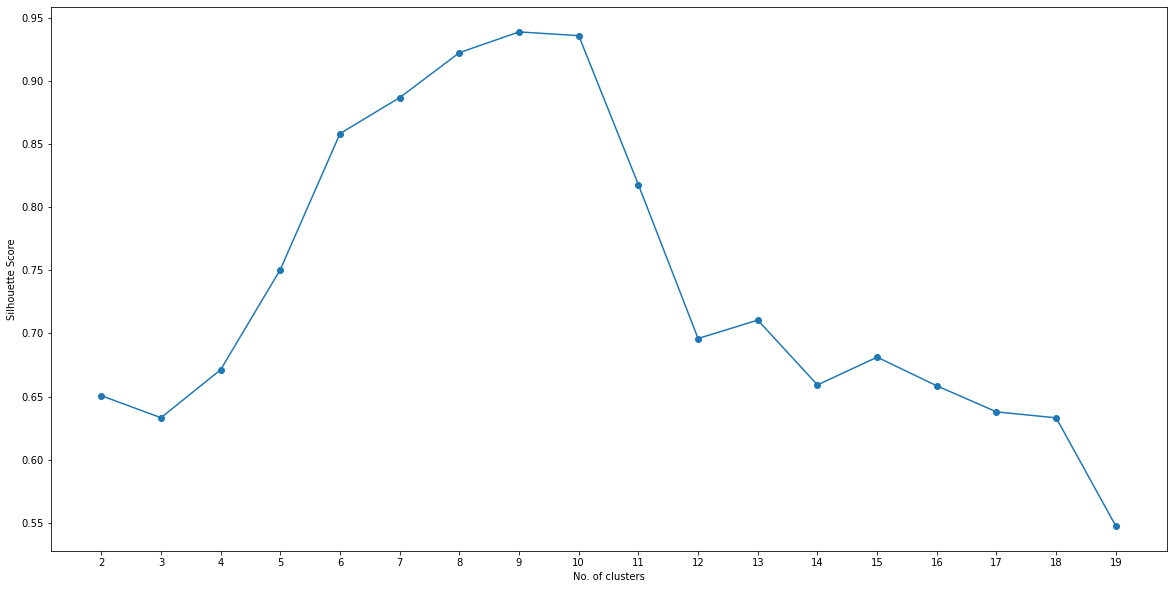

In [46]:
plot(max_range, scores, "No. of clusters", "Silhouette Score")

Based on silhouette_score the best number of clusters is 10, we'll use k=10 for the algorithm.

In [47]:
# run k-means clustering
kmeans = KMeans(n_clusters=10, random_state=0).fit(San_Francisco_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([2, 2, 0, 2, 2, 2, 2, 2, 5, 3, 3, 4, 3, 1, 2, 3, 8, 4, 5, 0, 5, 5,
       2, 4, 4, 0, 7, 1, 0, 6, 8, 1, 6, 0, 4, 2, 3, 0, 4, 4, 7, 5, 4, 2,
       0, 0, 4, 2, 2, 3, 4, 0, 3, 5, 1, 7, 2, 2, 0, 5, 5, 5, 7, 5, 5, 2,
       3, 3, 0, 4, 3, 4, 2, 2, 2, 2, 4, 4, 4, 0, 4, 0, 5, 2, 4, 4, 4, 2,
       2, 2, 2, 0, 4, 4, 0, 2, 7, 2, 9, 4, 3, 4, 4, 1, 2, 5, 1, 0, 0, 2,
       3, 0, 4, 0, 3, 5])

In [48]:
#adding cluster label to San Francisco's gyms dataframe
San_Francisco_gyms['Cluster']=kmeans.labels_

In [49]:
San_Francisco_gyms

,name,Latitude,Longitude,Gyms,Cluster
0,Seacliff,37.788540,-122.486920,0,2
1,Lake Street,37.785060,-122.464040,0,2
2,Presidio National Park,37.799930,-122.463580,2,0
3,Presidio Terrace,37.788260,-122.460800,0,2
4,Inner Richmond,37.780900,-122.465560,0,2
...,...,...,...,...,...
111,Corona Heights,37.763640,-122.440390,2,0
112,Ashbury Heights,37.764670,-122.445870,1,4
113,Eureka Valley,37.757501,-122.437941,2,0
114,St. Francis Wood,37.734650,-122.468030,4,3


To examine the clusters identified I want to aggregate for clusters and counting gyms in each cluster. 

Each cluster's coordinates are identified by using the average of the latitude and longitude in each cluster.

In [75]:
San_Francisco_grouped_clusters=San_Francisco_gyms.groupby('Cluster').agg({'Latitude':'mean', 'Longitude':'mean','Gyms':'sum'}).reset_index()
San_Francisco_grouped_clusters

,Cluster,Latitude,Longitude,Gyms
0,0,37.757576,-122.439539,38
1,1,37.782505,-122.413980,36
2,2,37.758625,-122.441638,0
3,3,37.764866,-122.442029,52
4,4,37.758477,-122.434021,25
5,5,37.752511,-122.437581,42
6,6,37.778950,-122.398707,16
7,7,37.760353,-122.433764,25
8,8,37.794835,-122.414810,14
9,9,37.965865,-121.722447,0


### Visualizing Clusters and the N° of Gyms per Cluster

Now it's time to get sense of the data analized and visualize them using Folium.

In [67]:
#visualizing the clusters
address ='San Francisco, California'
geoloc = Nominatim(user_agent='tumminellogiampaolo@yahoo.it')
location = geoloc.geocode(address)
latitude = location.latitude
longitude = location.longitude

San_Francisco_map2 = folium.Map(location=[latitude, longitude], zoom_start = 12)

for lat, lng, name, gyms in zip(San_Francisco_grouped_clusters['Latitude'], 
                          San_Francisco_grouped_clusters['Longitude'], 
                          San_Francisco_grouped_clusters['Cluster'],
                                San_Francisco_grouped_clusters['Gyms']):
    label = 'Cluster {}, {} gyms'.format(name, gyms)
    popup = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat, lng],
    radius = 5,
    popup = popup,
    color = 'green',
    fill = True,
    fill_color = '#3186cc',
    fill_opacity = 0.7,
    parse_html=False).add_to(San_Francisco_map2)
    
San_Francisco_map2

_If the map above isn't loading, check the 'San_Francisco_map_clusters.html' in this repository._

In [76]:
San_Francisco_map2.save('San_Francisco_map_clusters.html')

### Conclusions

As we can see, cluster 2 has no gyms, even if it is surrounded by other clusters containing lots of them (cluster 0: 38 gyms, cluster 3:52 gyms). This represents a great opportunity for entrepeneurs who wants to enter in the fitness industry in San Francisco. In fact it's resonable that a gyms in cluster 2 would have a good amount of clients, since other surrounding areas are crowded with gyms and no one is present there. Analizing the cluster 2 will give us more specifics.

In [78]:
San_Francisco_gyms[San_Francisco_gyms['Cluster']==2]

,name,Latitude,Longitude,Gyms,Cluster
0,Seacliff,37.788540,-122.486920,0,2
1,Lake Street,37.785060,-122.464040,0,2
3,Presidio Terrace,37.788260,-122.460800,0,2
4,Inner Richmond,37.780900,-122.465560,0,2
5,Sutro Heights,37.776128,-122.508119,0,2
6,Lincoln Park / Ft. Miley,37.781590,-122.494410,0,2
7,Outer Richmond,37.779580,-122.502410,0,2
14,Union Street,37.800263,-122.410614,0,2
22,Alamo Square,37.777220,-122.431460,0,2
35,Treasure Island,37.824890,-122.370870,0,2


A number of 110 neighborhoods doesn't have a gym in it. As stated before, this represents a good spot to enter in the fitness market and take advantage of the situation.

**Giampaolo Tumminello**